In [ ]:
import numpy as np
import cv2

In [ ]:
def scale_fun(v_, mean_i_, max_i_):
    r = 1.0 - mean_i_/max_i_    
    fv = lambda v : r * ( 1/(1+np.exp(-1.0*(v - mean_i_))) - 0.5 )
    
    fv_k_ = [fv(vk) for vk in v_]
    return fv_k_

def VIG(illuminace, inv_illuminace):
    """
    Generation of virtual exposure images(5 levels)
    """
    inv_illuminace /= np.max(inv_illuminace)
    mi = np.mean(illuminace)

    maxi = np.max(illuminace)
    v1 = 0.2;    v3 = mi;    v2 = 0.5 * (v1 + v3)
    v5 = 0.8;    v4 = 0.5 * (v3 + v5)
    v = [v1, v2, v3, v4, v5]
    fvk_list = scale_fun(v, mi, maxi)

    I_k = [(1 + fvk) * (illuminace + fvk * inv_illuminace) for fvk in fvk_list]  

    return I_k

In [1]:
def tonereproduct(bgr_image, L, R_, Ik_list, FLAG):
    """
    Fusion of multiple exposure images.
    """
    Lk_list = [ np.exp(R_) * Ik for Ik in Ik_list ] 
    L = L + 1e-22 

    rt = 1.0
    b, g, r = cv2.split(bgr_image)
    
    # Restore color image
    if FLAG == False:
        Sk_list = [cv2.merge((Lk*(b/L)**rt, Lk*(g/L)**rt, Lk*(r/L)**rt)) for Lk in Lk_list]
        return Sk_list[2]
    else:  # Weight maps

        Wk_list = []
        for index, Ik in enumerate(Ik_list):
            if index < 3:
                wk = Ik / np.max(Ik)
            else:
                temp = 0.5*(1 2- Ik)
                wk = temp / np.max(temp)
            Wk_list.append(wk)

        A = np.zeros_like(Wk_list[0])
        B = np.zeros_like(Wk_list[0])
        for lk, wk in zip(Lk_list, Wk_list):
            A = A + lk * wk 
            B = B + wk

        L_ = (A/B)
        ratio = np.clip(L_/L, 0, 3) # Clip unreasonable values
        b_ = ratio * b
        g_ = ratio * g
        r_ = ratio * r
        out = cv2.merge( ( b_, g_, r_ ) )
        return np.clip(out, 0.0, 1.0)

In [3]:
def SRS(reflectance, illuminace):
    """
    Stretch the pixel whose illuminace brighter than mean value 
    """
    r_R = 0.5
    def compare_func(r, i, m):    
        return r * (i/m)**r_R if i > m else r 

    srs_fun = np.vectorize(compare_func)
    mean_I = np.mean(illuminace)
    result = srs_fun(reflectance, illuminace, mean_I)
    return result

In [4]:
from scipy.sparse import spdiags
from scipy.sparse.linalg import spsolve, lsqr

def wlsFilter(IN, Lambda=1.0, Alpha=1.2):
    """
    IN        : Input image (2D grayscale image, type float)
    Lambda    : Balances between the data term and the smoothness term.
                Increasing lambda will produce smoother images.
                Default value is 1.0
    Alpha     : Gives a degree of control over the affinities by 
                non-lineary scaling the gradients. Increasing alpha 
                will result in sharper preserved edges. Default value: 1.2
    """
    
    
    L = np.log(IN+1e-22)        # Source image for the affinity matrix. log_e(IN)
    smallNum = 1e-6
    height, width = IN.shape
    k = height * width

    # Compute affinities between adjacent pixels based on gradients of L
    dy = np.diff(L, n=1, axis=0)   # axis=0 is vertical direction

    dy = -Lambda/(np.abs(dy)**Alpha + smallNum)
    dy = np.pad(dy, ((0,1),(0,0)), 'constant')    # add zeros row
    dy = dy.flatten(order='F')

    dx = np.diff(L, n=1, axis=1)

    dx = -Lambda/(np.abs(dx)**Alpha + smallNum)
    dx = np.pad(dx, ((0,0),(0,1)), 'constant')    # add zeros col 
    dx = dx.flatten(order='F')
    # Construct a five-point spatially inhomogeneous Laplacian matrix
    
    B = np.concatenate([[dx], [dy]], axis=0)
    d = np.array([-height,  -1])

    A = spdiags(B, d, k, k) 

    e = dx 
    w = np.pad(dx, (height, 0), 'constant'); w = w[0:-height]
    s = dy
    n = np.pad(dy, (1, 0), 'constant'); n = n[0:-1]

    D = 1.0 - (e + w + s + n)

    A = A + A.transpose() + spdiags(D, 0, k, k)

    # Solve
    OUT = spsolve(A, IN.flatten(order='F'))
    return np.reshape(OUT, (height, width), order='F') 

In [7]:
import matplotlib.pyplot as plt

def Show_origin_and_output(origin, I):
    """
    Show final result.
    """
    plt.figure(figsize=(12, 6))
    plt.subplots_adjust(left=0,right=1,bottom=0,top=1, wspace=0.005, hspace=0)

    plt.subplot(121),plt.imshow(np.flip(origin, 2)),plt.title('Origin')
    plt.axis('off')
    plt.subplot(122),plt.imshow(np.flip(I, 2)),plt.title('Fake HDR')
    plt.axis('off')
    plt.savefig('compare.png', bbox_inches='tight', pad_inches=0)
    plt.show()


class FakeHDR():

    def __init__(self, flag):
        self.weighted_fusion = flag
        self.wls = wlsFilter
        self.srs = SRS
        self.vig = VIG
        self.tonemap = tonereproduct

    def process(self, image):

        if image.shape[2] == 4:
            image = image[:,:,0:3]
        S = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)/255.0
        image = 1.0*image/255
        L = 1.0*S

        I = self.wls(S)
        R = np.log(L+1e-22) - np.log(I+1e-22)
        R_ = self.srs(R, L)
        I_K = self.vig(L, 1.0 - L)

        result_ = self.tonemap(image, L, R_, I_K, self.weighted_fusion)
        return result_

/opt/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


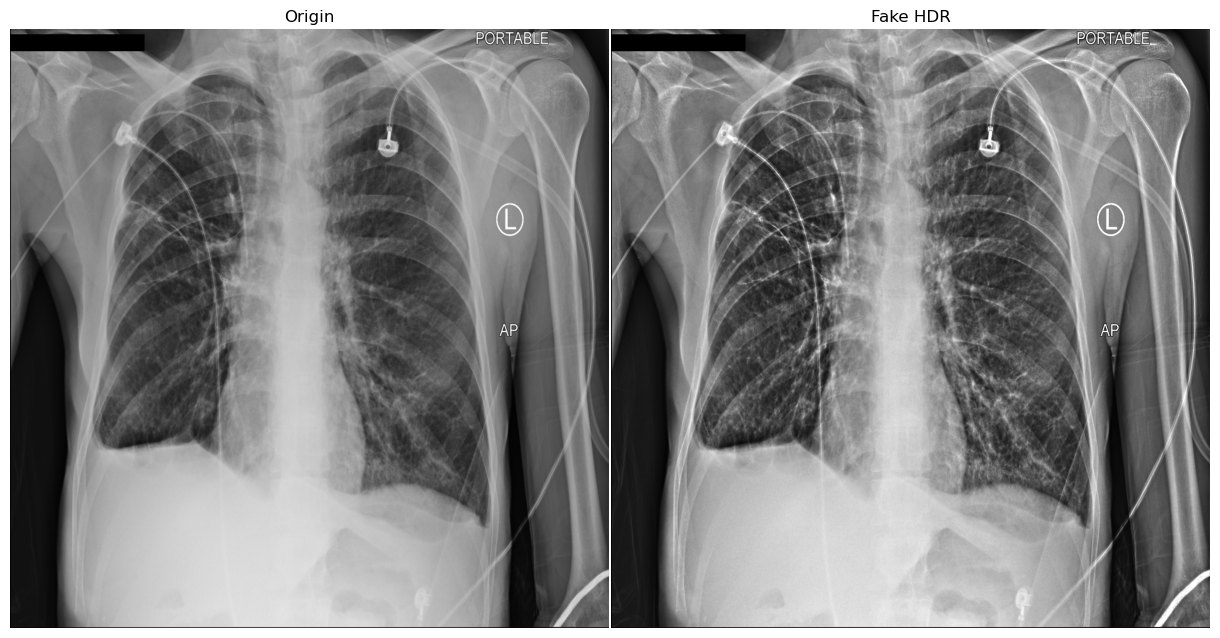

In [8]:
# Read image from file
image = cv2.imread('test.png')

# Add hdr filter
# True:  Using weighted fusion;  False: Averge fusion.
HDR_Filer = FakeHDR(True) 
output_image = HDR_Filer.process(image) 

# Save and show the final result 
cv2.imwrite('result.jpg', 255*output_image)
Show_origin_and_output(image, output_image)